# Setup

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import k_means
from sklearn.cluster import kmeans_plusplus
from sklearn.svm import SVC
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Softmax, Activation, SimpleRNN, Embedding, Conv2D
import tensorflow as tf
import seaborn as sns
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
import optuna

#I may change environs between desktop & laptop, so I run the below to check my WD and that multicore processing is still available.
print("WD:", os.getcwd())
print("CPU cores:", os.cpu_count())


# Part A: Model Code and Exploration (100 pts)

1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how impact how to proceed [10 pts]

In [348]:
full_train_data = pd.read_csv("8k_diabetes_train.csv",
                              na_values="?")
print("Length: ", len(full_train_data))
print("Width: ", len(full_train_data.columns))
print("Variables: ", full_train_data.columns)
full_train_data.head()

Length:  8000
Width:  40
Variables:  Index(['discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_diagnoses', 'max_glu_serum', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide.metformin',
       'glipizide.metformin', 'glimepiride.pioglitazone',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'readmitted', '2nd_diag', '3rd_diag', 'ai_response'],
      dtype='object')


,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,2nd_diag,3rd_diag,ai_response
0,Discharged to home,Transfer from a hospital,NaN,NaN,24,2,17,0,0,8,...,No,No,No,No,No,Yes,False,414,428,"Based on the diagnosis code 250.01, which indi..."
1,Discharged to home,Transfer from a hospital,NaN,NaN,37,3,14,0,0,8,...,No,No,No,No,No,Yes,False,410,414,"Based on the information provided, I recommend..."
2,Discharged to home,Emergency Room,SP,Emergency/Trauma,60,4,17,0,0,9,...,No,No,No,No,No,No,True,537,786,"Based on the information provided, the patient..."
3,Discharged to home,Emergency Room,NaN,NaN,40,3,25,1,0,9,...,No,No,No,No,Ch,Yes,True,425,428,"Based on the information provided, the patient..."
4,Discharged to home,Physician Referral,MD,Surgery-General,31,2,18,0,0,7,...,No,No,No,No,No,Yes,True,682,998,"Based on the information provided, the patient..."


In [349]:
# I investigated value counts for every variable. For brevity, I include only this one example in my final submission.
full_train_data.discharge_disposition_id.value_counts(dropna=False)

discharge_disposition_id
Discharged to home                                                                                             4864
Discharged/transferred to SNF                                                                                   954
Discharged/transferred to home with home health service                                                         920
NaN                                                                                                             364
Expired                                                                                                         153
Discharged/transferred to another short term hospital                                                           139
Discharged/transferred to another rehab fac including rehab units of a hospital.                                134
Discharged/transferred to another  type of inpatient care institution                                           130
Not Mapped                                     

In [350]:
full_train_data.payer_code.value_counts(dropna=False)

payer_code
NaN    4302
MC     1988
HM      364
BC      300
SP      242
UN      221
MD      189
CP      159
CM       88
DM       46
OG       39
PO       34
WC        9
SI        8
OT        6
CH        5
Name: count, dtype: int64

For "Payer Code" & "Medical Specialty", "?" is the largest class. I re-wrote my read_csv command to explicitly identify these as NAs. This is a lot of missing data for these columns. Next, I'll look at the distributions of the continuous variables.

In [351]:
# I also did the below for all other continuous variables. Those cells have been deleted from the final submission for brevity.
full_train_data.num_lab_procedures.describe()

count    8000.000000
mean       43.183375
std        19.518187
min         1.000000
25%        32.000000
50%        44.000000
75%        57.000000
max       120.000000
Name: num_lab_procedures, dtype: float64

In [352]:
# I use the below code to identify which columns have any NAs.
pd.isna(full_train_data).max()

discharge_disposition_id     True
admission_source_id          True
payer_code                   True
medical_specialty            True
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_diagnoses            False
max_glu_serum                True
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide               False
glipizide                   False
glyburide                   False
tolbutamide                 False
pioglitazone                False
rosiglitazone               False
acarbose                    False
miglitol                    False
troglitazone                False
tolazamide                  False
examide                     False
citoglipton                 False
insulin                     False
glyburide.metf

We have 8000 records of 39 features plus one target feature for readmission. We have a variety of continuous, categorical, and boolean variables, plus one string variable of text called "ai_response." For most of the continuous variables (and several of the others), there appear to be a small but not insignificant number of extreme outliers, I will want to keep this in mind when performing test_train_split and training.

Further, we have na values that we will want to somehow deal with in the variables: # Discharge_disposition_id, Admission_source_id, and Max_glu_serum, "Payer Code" & "Medical Specialty". I may also want to rename "?" values to proper NAs before doing so.

"2nd_diag" and "3rd_diag" are unclear. The name, repeated values, occasional letters & decimals all seem to imply diagnosis codes. As such, it may not be reasonable to try to impute the few NAs.

2. Pre-processed categorical data for use in the model and justified pre-processing
method. Note this may be different for each algorithm you try. [10 pts]

For simplicity, I might typically construct a class or pipeline that would perform pre-processing as part of the final model. However, to satisfy the structure of this assignment, I will instead perform pre-processing in discrete steps below (which will need to be repeated on the validation set later).

I address the columns in order, one at a time. First,  "discharge_disposition_id".

I believe this variable is best left as categorical (rather than ordinal), as there is no clear hierarchy of values. I believe "Not Mapped" should be NAs, and I reason that patients who die in care necessarily can't be readmitted, so other data about them may not be useful for predicting readmission. On inspection, I see no reasonable way to impute NAs as any other values.--The AI output seems to agree for many of those patients.

In [353]:
full_train_data.discharge_disposition_id = full_train_data.discharge_disposition_id.replace("Expired", np.nan)

In [354]:
full_train_data.discharge_disposition_id = full_train_data.discharge_disposition_id.replace("Not Mapped", np.nan)

In [355]:
# I confirm no zombies in our data:
full_train_data.loc[(full_train_data['discharge_disposition_id'] == "Expired")].readmitted.value_counts()

Series([], Name: count, dtype: int64)

In [356]:
full_train_data.discharge_disposition_id.value_counts()

discharge_disposition_id
Discharged to home                                                                                             4864
Discharged/transferred to SNF                                                                                   954
Discharged/transferred to home with home health service                                                         920
Discharged/transferred to another short term hospital                                                           139
Discharged/transferred to another rehab fac including rehab units of a hospital.                                134
Discharged/transferred to another  type of inpatient care institution                                           130
Discharged/transferred to ICF                                                                                    80
Discharged/transferred to a long term care hospital.                                                             39
Left AMA                                       

In [357]:
# # I use the following method for dropping rows because alternative methods can result in missing indices.
# # This method ensures that I will not encounter missing indices errors later on.
# indices_to_drop = full_train_data[full_train_data['discharge_disposition_id'] == "Expired"].index
# full_train_data.drop(index=indices_to_drop, inplace=True)
# #See how the indices are not decremented
# print("Index '135' is now labeled: ", full_train_data.iloc[135].name)
# # Check that rows have been successfully dropped.
# print("Undropped rows: ", len(full_train_data.loc[(full_train_data['discharge_disposition_id'] == "Expired")].readmitted.value_counts()))

In [358]:
# # I correct the index
# full_train_data.set_index(np.arange(len(full_train_data)), inplace=True)
# print("Index '135' is now labeled: ", full_train_data.iloc[135].name)

In [359]:
full_train_data.discharge_disposition_id.value_counts(dropna=False)

discharge_disposition_id
Discharged to home                                                                                             4864
Discharged/transferred to SNF                                                                                   954
Discharged/transferred to home with home health service                                                         920
NaN                                                                                                             624
Discharged/transferred to another short term hospital                                                           139
Discharged/transferred to another rehab fac including rehab units of a hospital.                                134
Discharged/transferred to another  type of inpatient care institution                                           130
Discharged/transferred to ICF                                                                                    80
Discharged/transferred to a long term care hosp

Next, admission_source_id. I replace "Not Mapped" with NA.
Additionally, I do not believe it is possible to impute NAs in any reasonable way. The distribution is relatively split across the two most prevalent categories, and there is no way to convert to numeric values.

In [360]:
full_train_data.admission_source_id = full_train_data.admission_source_id.replace("Not Mapped", np.nan)
full_train_data.admission_source_id = full_train_data.admission_source_id.replace("Not Available", np.nan)

In [361]:
full_train_data.admission_source_id.value_counts()

admission_source_id
Emergency Room                                    3957
Physician Referral                                2401
Transfer from a hospital                           328
Transfer from another health care facility         271
Clinic Referral                                    145
Transfer from a Skilled Nursing Facility (SNF)      93
HMO Referral                                        22
Court/Law Enforcement                                1
Name: count, dtype: int64

Next, payer_code. "?" have already been read as NAs by my read_csv command.

My intuition for imputing NAs is that "?" for payer_code may imply patients who either do not have a way to pay right away, or who cannot pay at all. This may correlate with socioeconomic status, an external variable that may influence readmission. However, I cannot confirm this, and it may be a risk to impute NAs (or designate them their own category) when they represent the bulk of the data. I *try* imputing NAs as their own category, but I may change this later and compare the effect on model performance.

In [362]:
#full_train_data.payer_code = full_train_data.payer_code.fillna("No_code")
full_train_data.payer_code.value_counts(dropna=False)

payer_code
NaN    4302
MC     1988
HM      364
BC      300
SP      242
UN      221
MD      189
CP      159
CM       88
DM       46
OG       39
PO       34
WC        9
SI        8
OT        6
CH        5
Name: count, dtype: int64

Next, medical_specialty. I replace obvious NAs. I also do not believe it is possible to simply impute NAs, as the data is categorical and NAs represent a sizable chunk of the data.

Given more time, it might be possible to do so using information from the "ai_response" column.

I do not change any other outliers or 'suspicious' values, as I am unsure if or how they should be recategorized. e.g. "Surgery-PlasticwithinHeadandNeck".

In [363]:
# Replacing obvious NA values
full_train_data.medical_specialty = full_train_data.medical_specialty.replace("PhysicianNotFound", np.nan)

Additionally, I prep medical_specialty for one-hot encoding by setting all but the 10 most common categories to NA. These also happen to be the only categories which each account for more than 1% of the data.

In [364]:
cols_to_keep = ("InternalMedicine", "Family/GeneralPractice", "Cardiology","Emergency/Trauma", "Surgery-General", "Orthopedics-Reconstructive", "Nephrology", "Psychiatry", "Orthopedics", "ObstetricsandGynecology")

full_train_data.loc[~full_train_data["medical_specialty"].isin(cols_to_keep), "medical_specialty"] = np.nan

In [365]:
full_train_data.medical_specialty.value_counts(dropna=False)

medical_specialty
NaN                           3997
InternalMedicine              1540
Family/GeneralPractice         685
Cardiology                     559
Emergency/Trauma               395
Surgery-General                271
Orthopedics-Reconstructive     133
Nephrology                     129
Psychiatry                     104
Orthopedics                    102
ObstetricsandGynecology         85
Name: count, dtype: int64

Next, max_glu_serum. I would consider this ordinal data, but not interval data, as I cannot confirm that the distance between "Norm" and ">200" is equal to the distance between ">200" and ">300". So I will One-Hot encode this variable at the end of this section, instead of label encoding.
Assuming these are readings for blood glucose serum test, I'm assuming it is only administered when there is a reasonable chance that the patient's blood glucose might be abnormal. As such, it may be reasonable to impute NAs as "Norm". However, I wound up making NAs their own category, since information may be gleaned from the fact that a doctor thought administration of a test was necessary at all, even if blood glucose came back normal.

In [366]:
full_train_data.max_glu_serum = full_train_data.max_glu_serum.fillna("No_test")
full_train_data.max_glu_serum.value_counts(dropna=False)

max_glu_serum
No_test    7466
Norm        271
>200        160
>300        103
Name: count, dtype: int64

Next, "Metformin" through "Insulin" appear to be ordinal, but not interval, same problem as above. I will one-hot encode these later. I drop acetohexamide, troglitazone, examide, and citoglipton because they contain only one value.

In [367]:
for col in full_train_data.columns[11:21]:
    print(col,":", len(full_train_data[col].unique()))

metformin : 4
repaglinide : 4
nateglinide : 4
chlorpropamide : 3
glimepiride : 4
acetohexamide : 1
glipizide : 4
glyburide : 4
tolbutamide : 2
pioglitazone : 4


In [368]:
full_train_data = full_train_data.drop(["acetohexamide",
                                        "troglitazone",
                                        "examide",
                                        "citoglipton"],
                                       axis=1)

Next, I drop nateglinide, chlorpropamide, tolbutamide, acarbose, miglitol, and tolazamide, because the "No" class represents 99% or more of records. 99% is an arbitrary threshold; realistically, I could probably drop even more of these columns.

In [369]:
for col in full_train_data.columns[11:24]:
    print(full_train_data[col].value_counts(),"\n")

metformin
No        6423
Steady    1444
Up          95
Down        38
Name: count, dtype: int64 

repaglinide
No        7892
Steady      92
Up          12
Down         4
Name: count, dtype: int64 

nateglinide
No        7957
Steady      41
Down         1
Up           1
Name: count, dtype: int64 

chlorpropamide
No        7989
Steady      10
Up           1
Name: count, dtype: int64 

glimepiride
No        7605
Steady     360
Up          27
Down         8
Name: count, dtype: int64 

glipizide
No        6946
Steady     940
Up          75
Down        39
Name: count, dtype: int64 

glyburide
No        7067
Steady     804
Up          81
Down        48
Name: count, dtype: int64 

tolbutamide
No        7998
Steady       2
Name: count, dtype: int64 

pioglitazone
No        7446
Steady     527
Up          20
Down         7
Name: count, dtype: int64 

rosiglitazone
No        7393
Steady     580
Up          19
Down         8
Name: count, dtype: int64 

acarbose
No        7975
Steady      24
Up    

In [370]:
full_train_data = full_train_data.drop(["nateglinide",
                                        "chlorpropamide",
                                        "tolbutamide",
                                        "acarbose",
                                        "miglitol",
                                        "tolazamide"],
                                       axis=1)

Next, I drop "glyburide.metformin" and "glipizide.metformin" because nearly all values are "no", and I drop "glimepiride.pioglitazone" through "metformin.pioglitazone" because they *only* contain "no" values.


In [371]:
#Print number of unique values
for col in full_train_data.columns[19:24]:
    print(col,":", len(full_train_data[col].unique()))

glyburide.metformin : 4
glipizide.metformin : 2
glimepiride.pioglitazone : 1
metformin.rosiglitazone : 1
metformin.pioglitazone : 1


In [372]:
full_train_data.value_counts("glyburide.metformin")
# 99.43% of the data is "no".

glyburide.metformin
No        7955
Steady      43
Down         1
Up           1
Name: count, dtype: int64

In [373]:
full_train_data.value_counts("glipizide.metformin")

glipizide.metformin
No        7998
Steady       2
Name: count, dtype: int64

In [374]:
full_train_data = full_train_data.drop(["glyburide.metformin",
                                        "glipizide.metformin",
                                        "glimepiride.pioglitazone",
                                        "metformin.rosiglitazone",
                                        "metformin.pioglitazone"],
                                       axis=1)

"change", "diabetes_med" and "readmitted" I encode as a binary. This is both to ensure it reads as a 0-1 or true-false to my model(s), and for interpretability. I also encode 'change' and 'diabetesMed" as objects to simply include them in the categorical set for OneHotEncoding later.

"readmitted" I pull out here to make my target vector

In [417]:
full_train_data.change = full_train_data.change.replace("Ch", 1)
full_train_data.change = full_train_data.change.replace("No", 0)
full_train_data.change = full_train_data.change.astype("object")


full_train_data.diabetesMed = full_train_data.diabetesMed.replace("Yes", 1)
full_train_data.diabetesMed = full_train_data.diabetesMed.replace("No", 0)
full_train_data.diabetesMed = full_train_data.diabetesMed.astype("object")

full_train_data.readmitted = full_train_data.readmitted.replace(True, 1)
full_train_data.readmitted = full_train_data.readmitted.replace(False, 0)
full_train_data_targetVector = np.array(full_train_data.readmitted)

"2nd_diag" and "3rd_diag". As stated above, I believe these may be diagnosis codes. This may be important information for predicting readmission. I can't impute NAs and I consider them as categorical. Below I ensure these columns are set as strings, rather than floats. There is no way to reasonably one-hot encode without either a) massively expanding the dimensionality of our data by 390 columns (nunique values) or b) cutting several categories which still contain many patients.  

In [419]:
full_train_data["2nd_diag"] = full_train_data["2nd_diag"].astype(str)
full_train_data["3rd_diag"] = full_train_data["3rd_diag"].astype(str)

In [420]:
# It is not possible for a column to have more than one datatype. I re-confirm that my index has been set correctly and that no glitches have occurred in type processing (by the absense of errors) in the below.
for j in ("2nd_diag", "3rd_diag"):
    for i in np.arange(len(full_train_data)):
        if type(full_train_data[j][i]) != str:
            print(j,i,type(full_train_data[j][i]))

In [421]:
# I set these aside as their own set, I may use them in their own model, or encode them with a different method than that used for the remainder of the categorical data.
diags_full_train_data = full_train_data[["2nd_diag", "3rd_diag"]]

In [422]:
diags_full_train_data

,2nd_diag,3rd_diag
0,414,428
1,410,414
2,537,786
3,425,428
4,682,998
...,...,...
7995,276,584
7996,309,496
7997,428,786
7998,401,493


In [423]:
ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=np.nan,
                                                   categories='auto')
diags_full_train_data_lenc = ordinal_encoder.fit_transform(diags_full_train_data)

In [424]:
np.unique(diags_full_train_data_lenc)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

My biggest lingering concern is how to encode these categorical variables. On one hand, multi-label encoding could cause my models to misinterpret categorical data as having an ordered, ratio relationship; on the other, one-hot encoding would explode the number of columns given the number of categories and categorical variables I have, possibly leading to high-dimensionality problems.

In [425]:
Cat_full_train_data = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "object"].index[0:15]].copy()

total_cols = 0

for col in Cat_full_train_data.columns:
    total_cols += Cat_full_train_data[col].nunique()
    print(col,":", len(Cat_full_train_data[col].unique()))
print("Intended OneHot cats: ", total_cols - 2)

discharge_disposition_id : 18
admission_source_id : 9
payer_code : 16
medical_specialty : 11
max_glu_serum : 4
metformin : 4
repaglinide : 4
glimepiride : 4
glipizide : 4
glyburide : 4
pioglitazone : 4
rosiglitazone : 4
insulin : 4
change : 2
diabetesMed : 2
Intended OneHot cats:  88


OneHotEncoder seems to have no simple method for handling NANs and plans to implement such a feature have not been followed up since 2020:
https://github.com/scikit-learn/scikit-learn/issues/11996
So, I will have to manually drop these columns from the sparse matrix.

In [426]:
ohe = skl.preprocessing.OneHotEncoder(drop='if_binary', 
                                      handle_unknown="ignore",
                                      sparse_output=False)
ohe.fit(Cat_full_train_data)
encCat_full_train_data = ohe.transform(Cat_full_train_data)
ohe.get_feature_names_out()

array(['discharge_disposition_id_Admitted as an inpatient to this hospital',
       'discharge_disposition_id_Discharged to home',
       'discharge_disposition_id_Discharged/transferred to ICF',
       'discharge_disposition_id_Discharged/transferred to SNF',
       'discharge_disposition_id_Discharged/transferred to a long term care hospital.',
       'discharge_disposition_id_Discharged/transferred to another  type of inpatient care institution',
       'discharge_disposition_id_Discharged/transferred to another rehab fac including rehab units of a hospital.',
       'discharge_disposition_id_Discharged/transferred to another short term hospital',
       'discharge_disposition_id_Discharged/transferred to home under care of Home IV provider',
       'discharge_disposition_id_Discharged/transferred to home with home health service',
       'discharge_disposition_id_Discharged/transferred within this institution to Medicare approved swing bed',
       'discharge_disposition_id_Dischar

In [427]:
cols_to_drop = set((17,26,42,53))
cols_to_keep = list(set(range(encCat_full_train_data.shape[1]))-cols_to_drop)
encCat_full_train_data = encCat_full_train_data[:, cols_to_keep]
print("OneHotCats: ", encCat_full_train_data.shape[1])

OneHotCats:  88


After experimentation at later steps, I find that one-hot encoding results in poor performance. So, I perform label encoding next (using ordinal Encoder). I will use this data with tree-based methods, so I do not have to worry as much about mistaken ordinality.

In [428]:
Cat_full_train_data

,discharge_disposition_id,admission_source_id,payer_code,medical_specialty,max_glu_serum,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed
0,Discharged to home,Transfer from a hospital,NaN,NaN,No_test,No,No,No,No,No,No,No,No,0,1
1,Discharged to home,Transfer from a hospital,NaN,NaN,No_test,No,No,No,No,Steady,No,No,No,0,1
2,Discharged to home,Emergency Room,SP,Emergency/Trauma,No_test,No,No,No,No,No,No,No,No,0,0
3,Discharged to home,Emergency Room,NaN,NaN,No_test,No,No,No,No,No,Steady,No,Down,1,1
4,Discharged to home,Physician Referral,MD,Surgery-General,No_test,Steady,No,No,No,No,No,No,No,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Discharged to home,Transfer from another health care facility,HM,NaN,No_test,No,No,No,No,No,No,No,Down,1,1
7996,Discharged to home,Emergency Room,MC,NaN,No_test,Steady,No,No,Steady,No,No,No,No,1,1
7997,Discharged to home,Emergency Room,MC,NaN,No_test,No,No,No,No,No,No,No,Up,1,1
7998,Discharged/transferred to home with home healt...,Emergency Room,NaN,NaN,No_test,No,No,No,No,No,No,No,No,0,0


In [429]:
categories = [['Admitted as an inpatient to this hospital', 'Discharged to home',
              'Discharged/transferred to ICF', 'Discharged/transferred to SNF',
              'Discharged/transferred to a long term care hospital.',
              'Discharged/transferred to another  type of inpatient care institution',
              'Discharged/transferred to another rehab fac including rehab units of a hospital.',
              'Discharged/transferred to another short term hospital',
              'Discharged/transferred to home under care of Home IV provider',
              'Discharged/transferred to home with home health service',
              'Discharged/transferred within this institution to Medicare approved swing bed',
              'Discharged/transferred/referred another institution for outpatient services',
              'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital',
              'Discharged/transferred/referred to this institution for outpatient services',
              'Hospice / home', 'Hospice / medical facility', 'Left AMA', np.nan],
              ['Clinic Referral', 'Court/Law Enforcement', 'Emergency Room',
               'HMO Referral', 'Physician Referral',
               'Transfer from a Skilled Nursing Facility (SNF)',
               'Transfer from a hospital',
               'Transfer from another health care facility', np.nan],
              ['BC', 'CH', 'CM', 'CP', 'DM', 'HM', 'MC', 'MD', 'OG', 'OT', 'PO',
               'SI', 'SP', 'UN', 'WC', np.nan],
              ['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
               'InternalMedicine', 'Nephrology', 'ObstetricsandGynecology',
               'Orthopedics', 'Orthopedics-Reconstructive', 'Psychiatry',
               'Surgery-General', np.nan],
              ['Norm', '>200', '>300', np.nan],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              ['No', 'Down', 'Steady', 'Up'],
              [0,1],
              [0,1]]
ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=np.nan,
                                                   categories=categories)
ordinal_encoder.fit(Cat_full_train_data)
lencCat_full_train_data = ordinal_encoder.transform(Cat_full_train_data)
lencCat_full_train_data

array([[ 1.,  6., nan, ...,  0.,  0.,  1.],
       [ 1.,  6., nan, ...,  0.,  0.,  1.],
       [ 1.,  2., 12., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  2.,  6., ...,  3.,  1.,  1.],
       [ 9.,  2., nan, ...,  0.,  0.,  0.],
       [ 3.,  2., nan, ...,  2.,  0.,  1.]])

In [430]:
ordinal_encoder.get_feature_names_out()

array(['discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'max_glu_serum', 'metformin', 'repaglinide',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed'], dtype=object)

3. Pre-processed numerical data appropriately including handling missing data and
justified methods used. Note this may be different for each algorithm you try. [10 pts]

We already confirmed above that there are no NAs in our continuous data, so no need to impute.

I choose to scale the numeric columns since all the model types I will implement work better with (or require) scaled data. I will also test each of my models with the unscaled numeric data and compare performance.

In [431]:
scaler = skl.preprocessing.StandardScaler()
#Create new df for scaled numeric data
num_full_train_data = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "int64"].index[0:6]].copy()

I experiment with capping outliers before scaling.

In [432]:
cap_values = {
    'num_medications': num_full_train_data['num_medications'].quantile(0.99),
    'number_outpatient': num_full_train_data['number_outpatient'].quantile(0.99),
    'number_emergency': num_full_train_data['number_emergency'].quantile(0.99),
}

num_full_train_data_capped = num_full_train_data.copy()

# Cap the values at their 99th percentile
for column, cap_value in cap_values.items():
    num_full_train_data_capped[column] = num_full_train_data[column].clip(upper=cap_value)

And finally, I scale.

In [433]:
scaledNum_full_train_data = scaler.fit_transform(num_full_train_data_capped)

While I'm at it, I also create a pairplot of my scaled numeric features for further EDA.

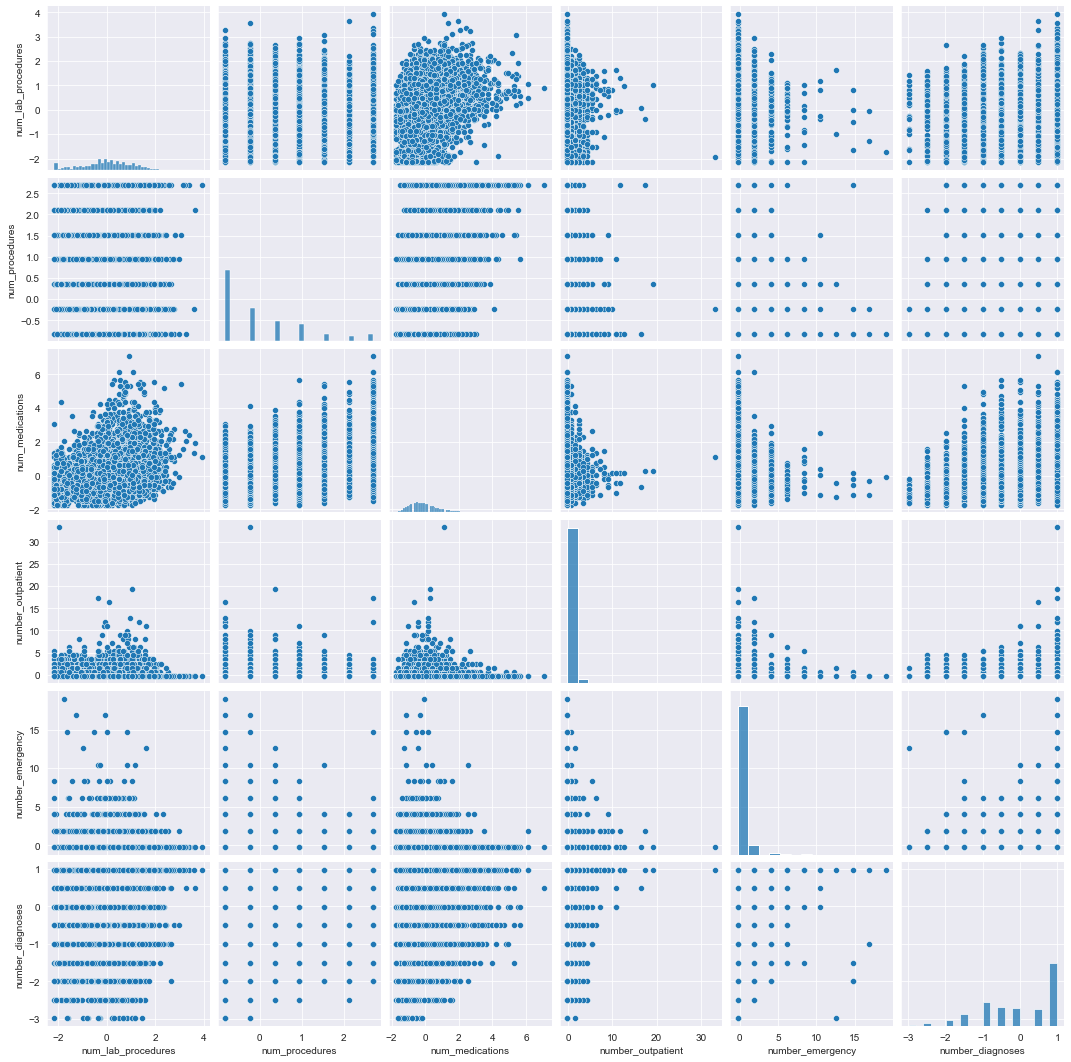

In [434]:
# I use a for loop to quickly transform all numeric columns in a format acceptable to seaborn.
scaler2 = skl.preprocessing.StandardScaler()

numeric_columns = list(full_train_data.dtypes[full_train_data.dtypes == "int64"].index)[0:6]

scaledNum_full_train_data2 = full_train_data[full_train_data.dtypes[full_train_data.dtypes == "int64"].index[0:6]].copy()

for column in numeric_columns:
    transformed_column = scaler2.fit_transform(np.array(full_train_data[column]).reshape(-1,1))
    scaledNum_full_train_data2[column] = transformed_column

sns.pairplot(scaledNum_full_train_data2)

No two remaining variables appear to be redundant or too heavily colinear. num_medications and num_lab_procedures seem to correlate somewhat, and as we will see later, they are particularly strong predictors or readmission.

4. Implement a model to make predictions using text data using tf-idf [20 pts]

Before I start:

For a time there was some disagreement between SKL's roc_auc_score and other ROC AUC scoring methods. This has since been fixed, but I construct the below to perform a manual k-fold cross validation with replacement as a quick way of checking that the results of a given "roc_auc_score" match the framework cross-validated roc_auc.

I'll continue to use my function for comparison since SKLearn's built-in cross-validation function saves outputs and will not shuffle and re-run operations on the same object with the same parameters, it will simply keep returning the same value. My function will allow me to loop over the data an arbitrary number of times, averaging to obtain a more accurate roc_auc score.

In [435]:
def customCrossVal(X, y = full_train_data_targetVector, model = None, metric = skl.metrics.roc_auc_score, loops: int = 5, stratify = True, test_size = 0.2):
    if stratify == True:
        strat = y
    else: strat = None
    scores = []
    # re-splits the data with re-shuffling & replacement
    for loop in np.arange(loops):
        _X_train, _X_test, _y_train, _y_test = train_test_split(
            X,
            y,
            stratify=strat,
            test_size=test_size,
            shuffle=True)
        model.fit(_X_train, _y_train)
        _probs = model.predict_proba(_X_test)[:,1]
        scores.append(metric(_y_test, _probs))
    return np.mean(scores)

I start by vectorizing the ai_response data

In [436]:
vectorizer = skl.feature_extraction.text.TfidfVectorizer(strip_accents = 'unicode',
                                                         norm = "l2")
textVect_full_train_data = vectorizer.fit_transform(full_train_data["ai_response"])
vectorizer.get_feature_names_out()

array(['01', '02', '03', ..., 'you', 'young', 'younger'], dtype=object)

I implement a test/train split.

In [395]:
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(
    textVect_full_train_data.toarray(), 
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2)

I experiment with Logistic Regression as a sort of baseline


In [519]:
textlrc = LogisticRegression(C=0.56,
                             penalty='l2',
                             solver='saga',
                             max_iter=10000)
textlrc.fit(text_X_train, text_y_train)
textlrc_preds = textlrc.predict(text_X_test)
textlrc_probs = textlrc.predict_proba(text_X_test)[:,1]

print("Model accuracy: ", skl.metrics.accuracy_score(text_y_test, textlrc_preds)) # 0.59
print("Model F1: ", skl.metrics.f1_score(text_y_test, textlrc_preds)) # 0.26
print("Model AUC: ", skl.metrics.roc_auc_score(text_y_test, textlrc_probs)) # 0.58
print("Model manual cross-val AUC: ", customCrossVal(X = textVect_full_train_data.toarray(),
                                                     model=textlrc,
                                                     loops=10))

Model accuracy:  0.5942675159235669
Model F1:  0.2635838150289017
Model AUC:  0.5488371468471371
Model manual cross-val AUC:  0.5660334588838758


I attempt classification with SVM. I choose SVMs because of their usefulness with high-dimensionality data. I also tested some RF & KNN models, but both models performed worse than SVMs. That code has been omitted from here for readability. Below is a randomized search, the parameter lists of which are themselves the result of extensive experimentation.

In [ ]:
### THE BELOW IS HASHED TO PREVENT RUNNING (>6 HRS on current i7 processor)
# start = datetime.datetime.now()
# parameters = {'C': [0.01, 0.1, 0.2, 0.3, 1, 10],
#               'degree': [1, 2],
#               'gamma': ['scale', 1, 5, 8, 10],
#               'class_weight': [{1: 0.9}, None, {1: 1.1}, 'balanced']}
# textsvc = skl.svm.SVC(kernel = 'poly')
# rs_textsvc = skl.model_selection.RandomizedSearchCV(textsvc,
#                                              parameters,
#                                              scoring="roc_auc",
#                                              n_jobs=-1,
#                                              verbose=3)
#
# rs_textsvc.fit(text_X_train, text_y_train)
#
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
#
# rs_textsvc.best_estimator_

In [ ]:
textsvc = skl.svm.SVC(kernel = 'rbf',
                      probability = True)
textsvc.fit(text_X_train, text_y_train)
svc_preds = textsvc.predict(text_X_test)
svc_probs = textsvc.predict_proba(text_X_test)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(text_y_test, svc_preds)) # 0.59
print("Model F1: ", skl.metrics.f1_score(text_y_test, svc_preds)) # 0.26
print("Model AUC: ", skl.metrics.roc_auc_score(text_y_test, svc_probs)) # 0.58

SVC achieves limited performance. Next I attempt a gradient boosted model.

I apply a gradient boosted classifier. I suspect that tree-based methods will be inefficient for high-dimensional data.

In [278]:
gbc_text = skl.ensemble.GradientBoostingClassifier()
gbc_text.fit(text_X_train, text_y_train)
gbc_text_preds = gbc_text.predict(text_X_test)
gbc_text_probs = gbc_text.predict_proba(text_X_test)[:,1]
print("Model accuracy: ", skl.metrics.accuracy_score(text_y_test, gbc_text_preds))
print("Model F1: ", skl.metrics.f1_score(text_y_test, gbc_text_preds))
print("Model ROC AUC: ", skl.metrics.roc_auc_score(text_y_test, gbc_text_probs))
print("Model Manual Cross-Validated AUC: ", customCrossVal(X = textVect_full_train_data,
                                                         model = gbc_text,
                                                         loops = 5))
# print("Model Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(gbc,
#                                                                                textVect_full_train_data,
#                                                                                full_train_data_targetVector,
#                                                                                scoring="roc_auc",
#                                                                                cv=10,
#                                                                                n_jobs=-1)))

Model accuracy:  0.5847133757961783
Model F1:  0.18703241895261846
Model ROC AUC:  0.528724722043184
Model Manual Cross-Validated AUC:  0.5607661268664732


Gradient boosting performs comparably poor.

Skip my experimentation with Neural Network application below

In [407]:
nn = Sequential()
nn.add(Flatten())
nn.add(Dense(1000, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))
# I don't like the idea of compiling with sigmoid as my last activation. However, softmax produces some complications which I have to avoid. NN optimization will be explored more in-depth in future assignments.
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

nn.fit(text_X_train, text_y_train)
nn_probs=nn.predict(text_X_test)
nn_preds=tf.greater(nn_probs, 0.5)

print("NN Accuracy: ", skl.metrics.accuracy_score(text_y_test, nn_preds))
print("NN F1: ", skl.metrics.f1_score(text_y_test, nn_preds))
print("NN AUC: ", skl.metrics.roc_auc_score(text_y_test, nn_probs))

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.5246 - loss: 0.6758
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN Accuracy:  0.5936305732484076
NN F1:  0.05341246290801187
NN AUC:  0.5613426858416586


For comparision, a simple untuned Naive Bayes achieves only somewhat worse performance than either of the models above.

In [279]:
naive_bayes_classifier = skl.naive_bayes.GaussianNB()
naive_bayes_classifier.fit(text_X_train, text_y_train)

#predicted y
NB_pred = naive_bayes_classifier.predict(text_X_test)
NB_probs = naive_bayes_classifier.predict_proba(text_X_test)[:,1]

print("Naive Bayes Accuracy: ", skl.metrics.accuracy_score(text_y_test, NB_pred))
print("Naive Bayes F1: ", skl.metrics.f1_score(text_y_test, NB_pred))
print("Naive Bayes AUC: ", skl.metrics.roc_auc_score(text_y_test, NB_probs))
print("Naive Bayes Manual Cross-Validated AUC: ", customCrossVal(X = textVect_full_train_data.toarray(),
                                                         model = naive_bayes_classifier,
                                                         loops = 10))
print("Naive Bayes Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(naive_bayes_classifier,
                                                                               textVect_full_train_data.toarray(),
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10,
                                                                               n_jobs=-1)))

Naive Bayes Accuracy:  0.43248407643312103
Naive Bayes F1:  0.5643031784841076
Naive Bayes AUC:  0.5040275204103556
Naive Bayes Manual Cross-Validated AUC:  0.5082566266516274
Naive Bayes Cross-Validated AUC:  0.5078127070008425


None of these models can achieve particularly good performance. None can achieve an accuracy greater than about 59% (and with very low F1 scores). Even our optimized SVM model can only achieve an AUC of 0.58. I select my optimized SVC as my final text classification model for stacking.

In [398]:
opt_textsvc = skl.svm.SVC(kernel = 'rbf',
                      probability = True)
opt_textsvc.fit(textVect_full_train_data, full_train_data_targetVector)

SVC(probability=True)

5. Use model stacking to incorporate tf-idf predictions for the text field
("ai_response") in the downstream algorithm [20 pts]

I ULTIMATELY DO THIS AS PART OF MY FINAL CUSTOM MODEL STACKING CLASSIFIER.

TO SEE MY WORK FOR THIS QUESTION **CTRL+F "customStackingClassifier"** and see my work at the end of question 6 & question 7.

I had to move my work for this section to incorporate work I do as part of questions 6.

6. Perform experimentation for multiple modeling algorithms and justify why you
selected the experiments you chose [20 pts]

First, I design & optimize a model for **categorical data** classification.

Test/train split

In [280]:
# One-hot-encoded data split
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(
    encCat_full_train_data,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2,
    random_state=42)

In [281]:
# Label-encoded data split
lcat_X_train, lcat_X_test, lcat_y_train, lcat_y_test = train_test_split(
    lencCat_full_train_data,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2)

LogReg Model on OHE categorical data

In [ ]:
# start = datetime.datetime.now()
# parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
#               'tol': [1e-5, 1e-4, 1e-3, 1e-2],
#               'C': [0.1, 0.9, 1, 1.1, 10, 100],
#               'class_weight': ['balanced', {1:0.8}, {1:0.9}, None, {1:1.1}],
#               'solver': ['linear', 'saga']}
#
# lrc = skl.linear_model.LogisticRegression(max_iter = 100000,
#                                           random_state = 42)
#
# gs_lrc = skl.model_selection.GridSearchCV(lrc,
#                                           parameters,
#                                           scoring="roc_auc",
#                                           n_jobs=-1
#                                           )
#
# gs_lrc.fit(cat_X_train, cat_y_train)
#
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
# gs_lrc.best_estimator_

In [282]:
lrc = skl.linear_model.LogisticRegression(max_iter = 100000,
                                          C=10,
                                          class_weight={1:0.9},
                                          penalty='l1',
                                          solver='saga',
                                          tol=0.01)

lrc.fit(cat_X_train, cat_y_train)
lrc_preds = lrc.predict(cat_X_test)
lrc_probs = lrc.predict_proba(cat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(cat_y_test, lrc_preds))
print("LRM F1: ", skl.metrics.f1_score(cat_y_test, lrc_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(cat_y_test, lrc_probs))

LRM Accuracy:  0.6076433121019108
LRM F1:  0.25961538461538464
LRM AUC:  0.603201538833387


RF Model on OHE categorical data

In [ ]:
# start = datetime.datetime.now()
# parameters = {'n_estimators': [100, 500, 1000],
#               'criterion': ['gini', 'entropy', 'log_loss'],
#               'max_features': ['sqrt', 'log2'],
#               'class_weight': ['balanced', {1:0.8}, {1:0.9}, None, {1:1.1}]}
#
# rfc = skl.ensemble.RandomForestClassifier(random_state = 42)
#
# gs_rfc = skl.model_selection.GridSearchCV(rfc,
#                                           parameters,
#                                           scoring="roc_auc",
#                                           n_jobs=-1
#                                           )
#
# gs_rfc.fit(cat_X_train, cat_y_train)
#
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
#
# gs_rfc.best_estimator_

In [283]:
rfc = skl.ensemble.RandomForestClassifier(n_estimators = 1000,
                                          random_state = 42,
                                          criterion = 'entropy',
                                          class_weight={1:0.9})
rfc.fit(cat_X_train, cat_y_train)
rfc_preds = rfc.predict(cat_X_test)
rfc_probs = rfc.predict_proba(cat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(cat_y_test, rfc_preds))
print("LRM F1: ", skl.metrics.f1_score(cat_y_test, rfc_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(cat_y_test, rfc_probs))

LRM Accuracy:  0.5910828025477707
LRM F1:  0.43485915492957744
LRM AUC:  0.5760226998066388


XGBoost Model on OHE data

In [284]:
cat_bst = XGBClassifier(booster = 'gbtree',
                        n_estimators=6, 
                        max_depth=9,
                        objective='binary:logistic')
# fit model
cat_bst.fit(cat_X_train, cat_y_train)
# make predictions
catBst_preds = cat_bst.predict(cat_X_test)
catBst_probs = cat_bst.predict_proba(cat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(cat_y_test, catBst_preds))
print("LRM F1: ", skl.metrics.f1_score(cat_y_test, catBst_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(cat_y_test, catBst_probs))

LRM Accuracy:  0.6114649681528662
LRM F1:  0.34968017057569295
LRM AUC:  0.6162374785154152


XGBoost on label-encoded data

In [77]:
lcat_bst = XGBClassifier(booster = 'gbtree',
                        n_estimators=5,
                        max_depth=9,
                        objective='binary:logistic')
# fit model
lcat_bst.fit(lcat_X_train, lcat_y_train)
# make predictions
lcatBst_preds = lcat_bst.predict(lcat_X_test)
lcatBst_probs = lcat_bst.predict_proba(lcat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(lcat_y_test, lcatBst_preds))
print("LRM F1: ", skl.metrics.f1_score(lcat_y_test, lcatBst_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(lcat_y_test, lcatBst_probs))

LRM Accuracy:  0.6019108280254777
LRM F1:  0.3615934627170582
LRM AUC:  0.596812392577076


SVMs on label-encoded data

In [285]:
cat_svm = skl.svm.SVC(probability=True)
# fit model
cat_svm.fit(cat_X_train, cat_y_train)
# make predictions
catSVM_preds = cat_svm.predict(cat_X_test)
catSVM_probs = cat_svm.predict_proba(cat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(catSVM_preds, cat_y_test))
print("LRM F1: ", skl.metrics.f1_score(catSVM_preds, cat_y_test))
print("LRM AUC: ", skl.metrics.roc_auc_score(cat_y_test, catSVM_probs))

LRM Accuracy:  0.6095541401273885
LRM F1:  0.2605548854041013
LRM AUC:  0.6212301267590504


Second, I design & optimize a model for **numeric data** classification

Test/train split

In [286]:
num_X_train, num_X_test, num_y_train, num_y_test = train_test_split(
    scaledNum_full_train_data,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2,
    random_state=42)

SVC with numeric data

In [82]:
num_svm = skl.svm.SVC(probability=True)
# fit model
num_svm.fit(cat_X_train, cat_y_train)
# make predictions
numSVM_preds = num_svm.predict(cat_X_test)
numSVM_probs = num_svm.predict_proba(cat_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(cat_y_test, numSVM_preds))
print("LRM F1: ", skl.metrics.f1_score(cat_y_test, numSVM_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(cat_y_test, numSVM_probs))

LRM Accuracy:  0.6095541401273885
LRM F1:  0.2605548854041013
LRM AUC:  0.6211999140616608


XGB Classifier with numeric data

In [79]:
num_bst = XGBClassifier(booster = 'gbtree',
                        n_estimators=3,
                        max_depth=3,
                        objective='binary:logistic')
# fit model
num_bst.fit(num_X_train, num_y_train)
# make predictions
numBst_preds = num_bst.predict(num_X_test)
numBst_probs = num_bst.predict_proba(num_X_test)[:,1]
print("LRM Accuracy: ", skl.metrics.accuracy_score(num_y_test, numBst_preds))
print("LRM F1: ", skl.metrics.f1_score(num_y_test, numBst_preds))
print("LRM AUC: ", skl.metrics.roc_auc_score(num_y_test, numBst_probs))
print("XGB Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(num_bst,
                                                                               num_full_train_data,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=5)))

LRM Accuracy:  0.6063694267515923
LRM F1:  0.17158176943699732
LRM AUC:  0.6092432390697176
XGB Cross-Validated AUC:  0.6147106574187349


I try a model for **combined data**.

First I decide what to combine. Experimentation reveals that:
* Imputing NA's rather than leaving them NA tends to reduce performance
* After much back-and-forth, it appears that including the label-encoded 2nd_diag & 3rd_diag data reduces performance, particularly for XGBoost & other tree-based methods. So I leave them out of my final model.
* Using the unscaled numeric data reduces performance for some models, so I stick with the scaled data.
    *   Tree-based methods like RF & XGB do not benefit from scaling, but I continue using the scaled data for the simplicity of not having yet another variable to track, since it should be the same either way.

In [287]:
comb_full_train_data = np.append(lencCat_full_train_data,
                                 scaledNum_full_train_data,
                                 axis=1)
#comb_full_train_data = np.append(comb_full_train_data,
#                                diags_full_train_data_lenc,
#                                axis = 1)
comb_full_train_data

# Columns correspond to
# 0:'discharge_disposition_id',
# 1:'admission_source_id',
# 2:'payer_code',
# 3:'medical_specialty',
# 4:'max_glu_serum',
# 5: 'metformin',
# 6:'repaglinide',
# 7:'glimepiride',
# 8:'glipizide',
# 9: 'glyburide',
# 10: 'pioglitazone',
# 11: 'rosiglitazone',
# 12:'insulin',
# 13: 'change',
# 14: 'diabetesMed',
# 15:'num_lab_procedures',
# 16:'num_procedures',
# 17:'num_medications',
# 18:'number_outpatient',
# 19:'number_emergency',
# 20:'number_diagnoses'
# 21:'2nd_diag'
# 22:'3rd_diag'

array([[ 1.        ,  6.        ,         nan, ..., -0.32202803,
        -0.2686923 ,  0.48699776],
       [ 1.        ,  6.        ,         nan, ..., -0.32202803,
        -0.2686923 ,  0.48699776],
       [ 1.        ,  2.        , 12.        , ..., -0.32202803,
        -0.2686923 ,  0.98066413],
       ...,
       [ 1.        ,  2.        ,  6.        , ..., -0.32202803,
        -0.2686923 ,  0.98066413],
       [ 9.        ,  2.        ,         nan, ..., -0.32202803,
        -0.2686923 , -1.48766774],
       [ 3.        ,  2.        ,         nan, ..., -0.32202803,
        -0.2686923 ,  0.98066413]])

Since earlier I imputed NAs where I believed that was reasonable, the remaining NAs are values that I believe can't be simply imputed by assuming they are the most frequent category. Here, I instead assign missing values to their own category (-1). All columns with remaining NAs were previously categorical.

In [288]:
#Only columns 0-4 contain NAs, but I code the below to cover all previously categorical columns for futureproofing.
cat_imputer1 = SimpleImputer(strategy='constant',
                             fill_value=-1)
#cat_imputer2 = SimpleImputer(strategy='median')
comb_full_train_data_imputed = comb_full_train_data.copy()
comb_full_train_data_imputed[:,0:15] = cat_imputer1.fit_transform(comb_full_train_data[:,0:15])
#comb_full_train_data_imputed[:,16:22] = cat_imputer2.fit_transform(comb_full_train_data[:,16:22])

#I experimented with dropping
#comb_full_train_data_imputed = comb_full_train_data_imputed[:,(0,1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)]
comb_full_train_data_imputed

array([[ 1.        ,  6.        , -1.        , ..., -0.32202803,
        -0.2686923 ,  0.48699776],
       [ 1.        ,  6.        , -1.        , ..., -0.32202803,
        -0.2686923 ,  0.48699776],
       [ 1.        ,  2.        , 12.        , ..., -0.32202803,
        -0.2686923 ,  0.98066413],
       ...,
       [ 1.        ,  2.        ,  6.        , ..., -0.32202803,
        -0.2686923 ,  0.98066413],
       [ 9.        ,  2.        , -1.        , ..., -0.32202803,
        -0.2686923 , -1.48766774],
       [ 3.        ,  2.        , -1.        , ..., -0.32202803,
        -0.2686923 ,  0.98066413]])

Imputing does not improve performance and in some places makes performance worse, so I only use the version of the data with imputed values for linear methods like LogReg & SVMs, which cannot handle NAs.

In [289]:
comb_X_train, comb_X_test, comb_y_train, comb_y_test = train_test_split(
    comb_full_train_data,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2)

In [290]:
combImp_X_train, combImp_X_test, combImp_y_train, combImp_y_test = train_test_split(
    comb_full_train_data_imputed,
    full_train_data_targetVector,
    stratify=full_train_data_targetVector,
    test_size=0.2)

Logistic regression on combined data

In [259]:
lrc = skl.linear_model.LogisticRegression(max_iter=1000)

lrc.fit(combImp_X_train, combImp_y_train)
lrc_preds = lrc.predict(combImp_X_test)
lrc_probs = lrc.predict_proba(combImp_X_test)[:,1]
print("LRC Accuracy: ", skl.metrics.accuracy_score(combImp_y_test, lrc_preds))
print("LRC F1: ", skl.metrics.f1_score(combImp_y_test, lrc_preds))
print("LRC AUC: ", skl.metrics.roc_auc_score(combImp_y_test, lrc_probs))
print("LRC Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data_imputed,
                                                         model = lrc,
                                                         loops = 10))
print("LRC Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(lrc,
                                                                               comb_full_train_data_imputed,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10,
                                                                               n_jobs=-1)))

LRC Accuracy:  0.6273885350318471
LRC F1:  0.3899895724713243
LRC AUC:  0.63034093350521
LRC Manual Cross-Validated AUC:  0.6273399734128263
LRC Cross-Validated AUC:  0.6258236588897574


SVM on combined data

I optimize my SVC with random search

In [ ]:
# # WILL TAKE VERY LONG TO RUN
# start = datetime.datetime.now()
# parameters = {'C': [0.01, 0.1, 0.2, 0.3, 1, 2],
#               'degree': [1, 2, 3],
#               'gamma': ['scale', 0.1, 1, 5, 8, 10],
#               'class_weight': [{1: 0.9}, None, {1: 1.1}, 'balanced']}
# svc = skl.svm.SVC(kernel = 'poly')
# rs_svc = skl.model_selection.RandomizedSearchCV(svc,
#                                           parameters,
#                                           scoring="roc_auc",
#                                           n_jobs=-1,
#                                           verbose = 3)
#
# rs_svc.fit(combImp_X_train, combImp_y_train)
#
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
#
# rs_svc.best_estimator_

In [291]:
svc = skl.svm.SVC(C=1,
                  kernel = 'poly',
                  class_weight='balanced',
                  degree = 1,
                  gamma = 'scale',
                  probability=True)

svc.fit(combImp_X_train, combImp_y_train)
svc_preds = svc.predict(combImp_X_test)
svc_probs = svc.predict_proba(combImp_X_test)[:,1]
print("SVC Accuracy: ", skl.metrics.accuracy_score(combImp_y_test, svc_preds))
print("SVC F1: ", skl.metrics.f1_score(combImp_y_test, svc_preds))
print("SVC AUC: ", skl.metrics.roc_auc_score(combImp_y_test, svc_probs))
print("SVC Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data_imputed,
                                                         model = svc,
                                                         loops = 10))
print("SVC Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(svc,
                                                                               comb_full_train_data_imputed,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10,
                                                                               n_jobs=-1)))

SVC Accuracy:  0.5789808917197452
SVC F1:  0.5506458191706323
SVC AUC:  0.6141334998388657
SVC Manual Cross-Validated AUC:  0.6260840483671716
SVC Cross-Validated AUC:  0.6229781375788358


I select this model to be one of my final models, so I train it on the full training data.

In [ ]:
opt_svc = skl.svm.SVC(C=1,
                  kernel='poly',
                  class_weight='balanced',
                  degree=1,
                  gamma='scale',
                  probability=True)

opt_svc.fit(comb_full_train_data_imputed, full_train_data_targetVector)

Naive Bayes classifier with imputed combined data.

In [161]:
gnbc = skl.naive_bayes.GaussianNB()

gnbc.fit(combImp_X_train, combImp_y_train)
gnbc_preds = gnbc.predict(combImp_X_test)
gnbc_probs = gnbc.predict_proba(combImp_X_test)[:,1]
print("Gaussian NB Accuracy: ", skl.metrics.accuracy_score(combImp_y_test, gnbc_preds))
print("Gaussian NB F1: ", skl.metrics.f1_score(combImp_y_test, gnbc_preds))
print("Gaussian NB AUC: ", skl.metrics.roc_auc_score(combImp_y_test, gnbc_probs))
print("Gaussian NB Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data_imputed,
                                                         model = gnbc,
                                                         loops = 50))
print("Gaussian NB Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(gnbc,
                                                                               comb_full_train_data_imputed,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10,
                                                                               n_jobs=-1)))

Gaussian NB Accuracy:  0.6171974522292993
Gaussian NB F1:  0.36803364879074657
Gaussian NB AUC:  0.631566226232678
Gaussian NB Manual Cross-Validated AUC:  0.6145316360511334
Gaussian NB Cross-Validated AUC:  0.6135452288212689


Gradient-Boosted classifier with combined data

I optimize my Gradient-boosted classifier with gridsearch.

The chosen hyperparameters and parameters are themselves the result of extensive experimentation.

In [228]:
# start = datetime.datetime.now()
# parameters = {'learning_rate': [0.075,0.09,0.1,0.11,0.2],
#               'n_estimators': [50,99,100,101,150,200,500]}
# gbc = skl.ensemble.GradientBoostingClassifier(criterion='friedman_mse',
#                                               loss = 'log_loss')
# gs_gbc = skl.model_selection.GridSearchCV(gbc,
#                                           parameters,
#                                           scoring="roc_auc",
#                                           n_jobs=-1,
#                                           verbose=1
#                                           )
#
# gs_gbc.fit(combImp_X_train, combImp_y_train)
#
# end = datetime.datetime.now()
# time_elapsed = end - start
# print("Time elapsed: ", time_elapsed)
#
# gs_gbc.best_estimator_

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Time elapsed:  0:00:13.629586


GradientBoostingClassifier(learning_rate=0.11)

In [160]:
gbc = skl.ensemble.GradientBoostingClassifier(criterion='friedman_mse',
                                              loss = 'log_loss',
                                              learning_rate = 0.11,
                                              n_estimators = 100)

gbc.fit(combImp_X_train, combImp_y_train)
GBC_preds = gbc.predict(combImp_X_test)
GBC_probs = gbc.predict_proba(combImp_X_test)[:,1]
print("GBC Accuracy: ", skl.metrics.accuracy_score(combImp_y_test, GBC_preds))
print("GBC F1: ", skl.metrics.f1_score(combImp_y_test, GBC_preds))
print("GBC AUC: ", skl.metrics.roc_auc_score(combImp_y_test, GBC_probs))
print("GBC Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data_imputed,
                                                                 model = gbc,
                                                                 loops = 10))
print("GBC Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(gbc,
                                                                                       comb_full_train_data_imputed,
                                                                                       full_train_data_targetVector,
                                                                                       scoring="roc_auc",
                                                                                       cv=10,
                                                                                       n_jobs=-1)))

GBC Accuracy:  0.6146496815286624
GBC F1:  0.3968095712861416
GBC AUC:  0.6505070697711892
GBC Manual Cross-Validated AUC:  0.6505458427328391
GBC Cross-Validated AUC:  0.6518059246526794


Given its performance, I choose this optimized model to be one of my final models.

In [ ]:
opt_gbc = skl.ensemble.GradientBoostingClassifier(criterion='friedman_mse',
                                              loss = 'log_loss',
                                              learning_rate = 0.11,
                                              n_estimators = 100)

opt_gbc.fit(comb_full_train_data_imputed, full_train_data_targetVector)

XGBoost classifier with combined data.

In [351]:
comb_bst = XGBClassifier()
# fit model
comb_bst.fit(comb_X_train, comb_y_train)
# make predictions
combBst_preds = comb_bst.predict(comb_X_test)
combBst_probs = comb_bst.predict_proba(comb_X_test)[:,1]
print("XGB Accuracy: ", skl.metrics.accuracy_score(comb_y_test, combBst_preds))
print("XGB F1: ", skl.metrics.f1_score(comb_y_test, combBst_preds))
print("XGB AUC: ", skl.metrics.roc_auc_score(comb_y_test, combBst_probs))
print("XGB Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data,
                                                  model = comb_bst,
                                                  loops = 10))
print("XGB Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(comb_bst,
                                                                               comb_full_train_data,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10,
                                                                               n_jobs=-1)))

XGB Accuracy:  0.632484076433121
XGB F1:  0.5114309906858594
XGB AUC:  0.6489435626812762
XGB Manual Cross-Validated AUC:  0.632643476742937
XGB Cross-Validated AUC:  0.6281040135222955


I optimize my XGBoost model with Optuna.
https://optuna.org/

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(comb_X_train, label=comb_y_train)
    dvalid = xgb.DMatrix(comb_X_test, label=comb_y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    roc_auc = skl.metrics.roc_auc_score(comb_y_test, pred_labels)
    return roc_auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Now I apply my optimized values to my XGBoost model

In [198]:
comb_bst = XGBClassifier(booster='gbtree',
                         grow_policy= 'depthwise',
                         min_child_weight = 101,
                         max_depth = 10,
                         alpha = 0.01,
                         reg_lambda=0.1,
                         colsample_bytree = 0.51,
                         eta = 0.2,
                         gamma = 0.019,
                         eval_metric = 'auc')
# fit model
comb_bst.fit(comb_X_train, comb_y_train)
# make predictions
combBst_preds = comb_bst.predict(comb_X_test)
combBst_probs = comb_bst.predict_proba(comb_X_test)[:,1]
print("XGB Accuracy: ", skl.metrics.accuracy_score(comb_y_test, combBst_preds))
print("XGB F1: ", skl.metrics.f1_score(comb_y_test, combBst_preds))
print("XGB AUC: ", skl.metrics.roc_auc_score(comb_y_test, combBst_probs))
print("XGB Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data,
                                           model = comb_bst,
                                           loops = 10))
print("XGB Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(comb_bst,
                                                                               comb_full_train_data,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10)))

XGB Accuracy:  0.6267515923566879
XGB F1:  0.45539033457249073
XGB AUC:  0.6541309149747556
XGB Manual Cross-Validated AUC:  0.6530968854065958
XGB Cross-Validated AUC:  0.6528603833188671


Given its performance, I select this model to be one of my final models, and train it on the full training dataset.

In [ ]:
opt_xgbc = XGBClassifier(booster='gbtree',
                         grow_policy= 'depthwise',
                         min_child_weight = 101,
                         max_depth = 10,
                         alpha = 0.01,
                         reg_lambda=0.1,
                         colsample_bytree = 0.51,
                         eta = 0.2,
                         gamma = 0.019,
                         eval_metric = 'auc')
# fit model
opt_xgbc.fit(comb_full_train_data_imputed, full_train_data_targetVector)

I use my xgboost model to visualize feature importance.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

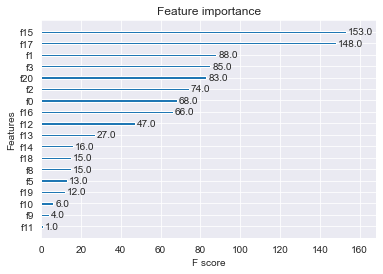

In [77]:
xgb.plot_importance(comb_bst)
# Columns correspond to:
# 0:'discharge_disposition_id',
# 1:'admission_source_id',
# 2:'payer_code',
# 3:'medical_specialty',
# 4:'max_glu_serum',
# 5: 'metformin',
# 6:'repaglinide',
# 7:'glimepiride',
# 8:'glipizide',
# 9: 'glyburide',
# 10: 'pioglitazone',
# 11: 'rosiglitazone',
# 12:'insulin',
# 13: 'change',
# 14: 'diabetesMed',
# 15:'num_lab_procedures',
# 16:'num_procedures',
# 17:'num_medications',
# 18:'number_outpatient',
# 19:'number_emergency',
# 20:'number_diagnoses'
# 21:'2nd_diag'
# 22:'3rd_diag'

Num medications & num lab procedures appear to hold the most predictive power.

**Model Stacking**

After extensive testing and optimization of different models, the Optuna optimized XGBoost model working on combined data (both the encoded categorical data and the numeric data) achieves the best performance (AUC ~0.65).

My intuition is that the GB model might be redundant if I am already including an XGBoost model, since GB is tree-based like XGBoost, but experimentation finds that including it in my stacked model improves performance.

In [ ]:
Model_1 = opt_gbc
Model_2 = opt_xgbc
Model_3 = opt_svc
final_estimator = LogisticRegression(solver = 'saga',
                                 penalty = 'l1')

stackCL = skl.ensemble.StackingClassifier([('Model_1', Model_1),
                                           ('Model_2', Model_2),
                                           ('Model_3', Model_3)],
                                          final_estimator = final_estimator)

stackCL.fit(combImp_X_train, combImp_y_train)

stack_preds = stackCL.predict(combImp_X_test)
stack_probs = stackCL.predict_proba(combImp_X_test)[:,1]

print("Stacking Model Accuracy: ", skl.metrics.accuracy_score(combImp_y_test, stack_preds))
print("Stacking Model F1: ", skl.metrics.f1_score(combImp_y_test, stack_preds))
print("Stacking Model AUC: ", skl.metrics.roc_auc_score(combImp_y_test, stack_probs))
print("Stacking Model Manual Cross-Validated AUC: ", customCrossVal(X = comb_full_train_data_imputed,
                                                         model = stackCL,
                                                         loops = 10)) # 0.6584775989633689
print("Stacking Model Cross-Validated AUC: ", np.mean(skl.model_selection.cross_val_score(stackCL,
                                                                               comb_full_train_data_imputed,
                                                                               full_train_data_targetVector,
                                                                               scoring="roc_auc",
                                                                               cv=10))) # 0.6552334801291952

**Custom Stacking Model**
Next, I build *my own* preprocessor & stacking classifier

In [ ]:
class customStackingClassifier:
    """
    Custom stacking classifier for this dataset.

    Parameters
    __________
    categorical_transformer : fitted OneHotEncoder object
            Fitted encoder for categorical data
    numeric_transformer: fitted StandardScalar object
            Fitted StandardScaler for numeric data
    text_transformer : fitted TfidfVectorizer object
            Fitted TfidfVectorizer for text data
    X_train : unprocessed diabetes training data
    models 1-3 : fitted model objects
            fitted on combined imputed diabetes data
    final_estimator : estimator object
            Classifier for combined models' predictions (default is Logistic Regression).
    text_model :

    """
    def __init__(self, categorical_transformer = None, numeric_transformer = None, text_transformer = None, X_train = pd.core.frame.DataFrame, model_1 = None, model_2 = None, model_3 = None, text_model = None, final_estimator = LogisticRegression()):
        self._categorical_transformer = categorical_transformer
        self._numeric_transformer = numeric_transformer
        self._text_transformer = text_transformer
        self._X_train = X_train
        self._model_1 = model_1
        self._model_2 = model_2
        self._model_3 = model_3
        self._text_model = text_model
        self._final_estimator = final_estimator

    def preprocess_training(self, train_data: pd.core.frame.DataFrame):
        """
        Preprocess the data.

        :train_data: diabetes data dataframe.
        :return: preprocessed dataframe.
        """
        # Adapted from all above
        transformed_data = train_data.copy()
        transformed_data.discharge_disposition_id = transformed_data.discharge_disposition_id.replace("Not Mapped", np.nan)
        transformed_data.discharge_disposition_id = transformed_data.discharge_disposition_id.replace("Expired", np.nan)
        # transformed_data.drop(index=transformed_data[transformed_data['discharge_disposition_id'] == "Expired"].index, inplace=True)
        # transformed_data.set_index(np.arange(len(transformed_data)), inplace=True)
        transformed_data.admission_source_id = transformed_data.admission_source_id.replace("Not Mapped", np.nan)
        #transformed_data.payer_code = transformed_data.payer_code.fillna("No_code")
        transformed_data.medical_specialty = transformed_data.medical_specialty.replace("PhysicianNotFound", np.nan)
        transformed_data.loc[~transformed_data["medical_specialty"].isin(("InternalMedicine", "Family/GeneralPractice", "Cardiology","Emergency/Trauma", "Surgery-General", "Orthopedics-Reconstructive", "Nephrology", "Psychiatry", "Orthopedics", "ObstetricsandGynecology")), "medical_specialty"] = np.nan
        transformed_data.max_glu_serum = transformed_data.max_glu_serum.fillna("No_test")

        #Drop columns
        transformed_data = transformed_data.drop(["acetohexamide",
                                                  "troglitazone",
                                                  "examide",
                                                  "citoglipton",
                                                  "nateglinide",
                                                  "chlorpropamide",
                                                  "tolbutamide",
                                                  "acarbose",
                                                  "miglitol",
                                                  "tolazamide",
                                                  "glyburide.metformin",
                                                  "glipizide.metformin",
                                                  "glimepiride.pioglitazone",
                                                  "metformin.rosiglitazone",
                                                  "metformin.pioglitazone"],
                                                 axis=1)
        #transform binaries
        transformed_data.change = transformed_data.change.replace("No", 0)
        transformed_data.change = transformed_data.change.replace("Ch", 1)
        transformed_data.change = transformed_data.change.astype("object")
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("Yes", 1)
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("No", 0)
        transformed_data.diabetesMed = transformed_data.diabetesMed.astype("object")
        #Create target vector
        transformed_data.readmitted = transformed_data.readmitted.replace(True, 1)
        transformed_data.readmitted = transformed_data.readmitted.replace(False, 0)
        _full_train_data_targetVector = np.array(transformed_data.readmitted)
        self._full_train_data_targetVector = _full_train_data_targetVector
        # get categorical columns
        _cat_full_train_data = transformed_data[transformed_data.dtypes[transformed_data.dtypes == "object"].index[0:15]]
        self._cat_full_train_data = _cat_full_train_data
        #include diag cats
        # _diags_full_train_data = transformed_data[["2nd_diag", "3rd_diag"]]
        # _diag_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
        #                                                  unknown_value=np.nan,
        #                                                  categories='auto')
        # _diags_full_train_data_lenc = _diag_encoder.fit_transform(_diags_full_train_data)
        #label encoding categoricals
        _categories = [['Admitted as an inpatient to this hospital', 'Discharged to home',
                       'Discharged/transferred to ICF', 'Discharged/transferred to SNF',
                       'Discharged/transferred to a long term care hospital.',
                       'Discharged/transferred to another  type of inpatient care institution',
                       'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                       'Discharged/transferred to another short term hospital',
                       'Discharged/transferred to home under care of Home IV provider',
                       'Discharged/transferred to home with home health service',
                       'Discharged/transferred within this institution to Medicare approved swing bed',
                       'Discharged/transferred/referred another institution for outpatient services',
                       'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital',
                       'Discharged/transferred/referred to this institution for outpatient services',
                       'Hospice / home', 'Hospice / medical facility', 'Left AMA', 'Expired', np.nan],
                      ['Clinic Referral', 'Court/Law Enforcement', 'Emergency Room',
                       'HMO Referral', 'Physician Referral',
                       'Transfer from a Skilled Nursing Facility (SNF)',
                       'Transfer from a hospital',
                       'Transfer from another health care facility', np.nan],
                      ['BC', 'CH', 'CM', 'CP', 'DM', 'HM', 'MC', 'MD', 'OG', 'OT', 'PO',
                       'SI', 'SP', 'UN', 'WC', np.nan],
                      ['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
                       'InternalMedicine', 'Nephrology', 'ObstetricsandGynecology',
                       'Orthopedics', 'Orthopedics-Reconstructive', 'Psychiatry',
                       'Surgery-General', np.nan],
                      ['Norm', '>200', '>300', np.nan],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      ['No', 'Down', 'Steady', 'Up'],
                      [0,1],
                      [0,1]]
        _ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                            unknown_value=np.nan,
                                                            categories=categories)
        _lencCat_full_train_data = _ordinal_encoder.fit_transform(_cat_full_train_data)
        self._lencCat_full_train_data = _lencCat_full_train_data
        # Cap numeric at 99th percentile
        _num_full_train_data = transformed_data[transformed_data.dtypes[transformed_data.dtypes == "int64"].index[0:6]]
        _cap_values = {
            'num_medications': _num_full_train_data['num_medications'].quantile(0.99),
            'number_outpatient': _num_full_train_data['number_outpatient'].quantile(0.99),
            'number_emergency': _num_full_train_data['number_emergency'].quantile(0.99),
        }
        _num_full_train_data_capped = _num_full_train_data.copy()
        for column, cap_value in cap_values.items():
            _num_full_train_data_capped[column] = _num_full_train_data[column].clip(upper=cap_value)
        #Scaling numeric
        _scaledNum_full_train_data = self._numeric_transformer.transform(_num_full_train_data_capped)
        self._scaledNum_full_train_data = _scaledNum_full_train_data
        #Create combined data
        _comb_full_train_data = np.append(_lencCat_full_train_data,
                                         _scaledNum_full_train_data,
                                         axis=1)
        # _comb_full_train_data = np.append(_comb_full_train_data,
        #                                  _diags_full_train_data_lenc,
        #                                  axis = 1)
        #Late imputing
        _cat_imputer2 = SimpleImputer(strategy='constant',
                                      fill_value=-1)
        _comb_full_train_data_imputed = _comb_full_train_data.copy()
        _comb_full_train_data_imputed[:,0:15] = _cat_imputer2.fit_transform(_comb_full_train_data[:,0:15])
        self._comb_full_train_data_imputed = _comb_full_train_data_imputed
        #encoding text
        _textVect_full_train_data = self._text_transformer.transform(transformed_data["ai_response"])
        self._textVect_full_train_data = _textVect_full_train_data
        return self._comb_full_train_data_imputed, self._textVect_full_train_data, self._full_train_data_targetVector

    def preprocess_testing(self, X_test: pd.core.frame.DataFrame):
        """
        Preprocess the data.

        :X_test: diabetes data dataframe.
        :return: preprocessed dataframe.
        """
        #Imputing and dropping
        transformed_data = X_test.copy()
        transformed_data.discharge_disposition_id = transformed_data.discharge_disposition_id.replace("Not Mapped", np.nan)
        transformed_data.discharge_disposition_id = transformed_data.discharge_disposition_id.replace("Expired", np.nan)
        # transformed_data[transformed_data['discharge_disposition_id'] == "Expired"]
        # transformed_data.set_index(np.arange(len(transformed_data)), inplace=True)
        transformed_data.admission_source_id = transformed_data.admission_source_id.replace("Not Mapped", np.nan)
        #transformed_data.payer_code = transformed_data.payer_code.fillna("No_code")
        transformed_data.medical_specialty = transformed_data.medical_specialty.replace("PhysicianNotFound", np.nan)
        transformed_data.loc[~transformed_data["medical_specialty"].isin(("InternalMedicine", "Family/GeneralPractice", "Cardiology","Emergency/Trauma", "Surgery-General", "Orthopedics-Reconstructive", "Nephrology", "Psychiatry", "Orthopedics", "ObstetricsandGynecology")), "medical_specialty"] = np.nan
        transformed_data.max_glu_serum = transformed_data.max_glu_serum.fillna("No_test")
        transformed_data = transformed_data.drop(["acetohexamide",
                                                  "troglitazone",
                                                  "examide",
                                                  "citoglipton",
                                                  "nateglinide",
                                                  "chlorpropamide",
                                                  "tolbutamide",
                                                  "acarbose",
                                                  "miglitol",
                                                  "tolazamide",
                                                  "glyburide.metformin",
                                                  "glipizide.metformin",
                                                  "glimepiride.pioglitazone",
                                                  "metformin.rosiglitazone",
                                                  "metformin.pioglitazone"],
                                                 axis=1)
        #make binaries
        transformed_data.change = transformed_data.change.replace("No", 0)
        transformed_data.change = transformed_data.change.replace("Ch", 1)
        transformed_data.change = transformed_data.change.astype("object")
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("Yes", 1)
        transformed_data.diabetesMed = transformed_data.diabetesMed.replace("No", 0)
        transformed_data.diabetesMed = transformed_data.diabetesMed.astype("object")
        # NO TARGET VECTOR
        # get categorical columns
        _cat_full_test_data = transformed_data[transformed_data.dtypes[transformed_data.dtypes == "object"].index[0:15]]
        self._cat_full_test_data = _cat_full_test_data
        # #include diag cats
        # _diags_full_test_data = transformed_data[["2nd_diag", "3rd_diag"]]
        # _diag_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
        #                                                  unknown_value=np.nan,
        #                                                  categories='auto')
        # _diags_full_test_data_lenc = _diag_encoder.fit_transform(_diags_full_test_data)

        #label encode categoricals
        _categories = [['Admitted as an inpatient to this hospital', 'Discharged to home',
                        'Discharged/transferred to ICF', 'Discharged/transferred to SNF',
                        'Discharged/transferred to a long term care hospital.',
                        'Discharged/transferred to another  type of inpatient care institution',
                        'Discharged/transferred to another rehab fac including rehab units of a hospital.',
                        'Discharged/transferred to another short term hospital',
                        'Discharged/transferred to home under care of Home IV provider',
                        'Discharged/transferred to home with home health service',
                        'Discharged/transferred within this institution to Medicare approved swing bed',
                        'Discharged/transferred/referred another institution for outpatient services',
                        'Discharged/transferred/referred to a psychiatric hospital of a psychiatric distinct part unit of a hospital',
                        'Discharged/transferred/referred to this institution for outpatient services',
                        'Hospice / home', 'Hospice / medical facility', 'Left AMA', np.nan],
                       ['Clinic Referral', 'Court/Law Enforcement', 'Emergency Room',
                        'HMO Referral', 'Physician Referral',
                        'Transfer from a Skilled Nursing Facility (SNF)',
                        'Transfer from a hospital',
                        'Transfer from another health care facility', np.nan],
                       ['BC', 'CH', 'CM', 'CP', 'DM', 'HM', 'MC', 'MD', 'OG', 'OT', 'PO',
                        'SI', 'SP', 'UN', 'WC', np.nan],
                       ['Cardiology', 'Emergency/Trauma', 'Family/GeneralPractice',
                        'InternalMedicine', 'Nephrology', 'ObstetricsandGynecology',
                        'Orthopedics', 'Orthopedics-Reconstructive', 'Psychiatry',
                        'Surgery-General', np.nan],
                       ['Norm', '>200', '>300', np.nan],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       ['No', 'Down', 'Steady', 'Up'],
                       [0,1],
                       [0,1]]
        _ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                            unknown_value=np.nan,
                                                            categories=categories)
        _lencCat_full_test_data = _ordinal_encoder.fit(self._cat_full_train_data)
        _lencCat_full_test_data = _ordinal_encoder.transform(transformed_data[transformed_data.dtypes[transformed_data.dtypes == "object"].index[0:15]])
        self._lencCat_full_test_data = _lencCat_full_test_data

        #Cap numeric at 99th percentile
        _num_full_test_data = transformed_data[transformed_data.dtypes[transformed_data.dtypes == "int64"].index[0:6]]
        _cap_values = {
            'num_medications': _num_full_test_data['num_medications'].quantile(0.99),
            'number_outpatient': _num_full_test_data['number_outpatient'].quantile(0.99),
            'number_emergency': _num_full_test_data['number_emergency'].quantile(0.99),
        }
        _num_full_test_data_capped = _num_full_test_data.copy()
        for column, cap_value in cap_values.items():
            _num_full_test_data_capped[column] = _num_full_test_data[column].clip(upper=cap_value)

        #scale numeric data
        _scaledNum_full_test_data = self._numeric_transformer.transform(_num_full_test_data_capped)
        self._scaledNum_full_test_data = _scaledNum_full_test_data

        #create combined df
        _comb_full_test_data = np.append(_lencCat_full_test_data,
                                         _scaledNum_full_test_data,
                                         axis=1)

        # _comb_full_test_data = np.append(_comb_full_test_data,
        #                                  _diags_full_test_data_lenc,
        #                                  axis = 1)

        # late imputing
        _cat_imputer2 = SimpleImputer(strategy='constant',
                                     fill_value=-1)
        _comb_full_test_data_imputed = _comb_full_test_data.copy()
        _comb_full_test_data_imputed[:,0:15] = _cat_imputer2.fit_transform(_comb_full_test_data[:,0:15])
        self._comb_full_test_data_imputed = _comb_full_test_data_imputed
        #encode text data
        _textVect_full_test_data = self._text_transformer.transform(transformed_data["ai_response"])
        self._textVect_full_test_data = _textVect_full_test_data
        return self._comb_full_test_data_imputed, self._textVect_full_test_data

    def fit(self, X_train, X_train_text,  y_train):
        """
        Fit estimators to training data
        :return: self
        """
        self._model_probabilities = np.empty((X_train.shape[0],4))
        print("Predicting training data with model 1")
        self._model_probabilities[:,0] = self._model_1.predict_proba(X_train)[:,1]
        print("Predicting training data with model 2")
        self._model_probabilities[:,1] = self._model_2.predict_proba(X_train)[:,1]
        print("Predicting training data with model 3")
        self._model_probabilities[:,2] = self._model_3.predict_proba(X_train)[:,1]
        print("Predicting training data with text model")
        self._model_probabilities[:,3] = self._text_model.predict_proba(X_train_text)[:,1]
        print("Fitting final estimator")
        self._final_estimator.fit(self._model_probabilities, y_train)
        return self

    def predict_proba(self, X_test, X_test_text):
        """
        Predict probabilities
        :return: self
        """
        _model_probabilities = np.empty((X_test.shape[0],4))
        print("Predicting testing data with model 1")
        _model_probabilities[:,0] = self._model_1.predict_proba(X_test)[:,1]
        print("Predicting testing data with model 2")
        _model_probabilities[:,1] = self._model_2.predict_proba(X_test)[:,1]
        print("Predicting testing data with model 3")
        _model_probabilities[:,2] = self._model_3.predict_proba(X_test)[:,1]
        print("Predicting testing data with text model")
        _model_probabilities[:,3] = self._text_model.predict_proba(X_test_text)[:,1]
        print("Predicting testing data with final estimator")
        self.probs = self._final_estimator.predict_proba(_model_probabilities)
        return self.probs

    def predict(self, X_test, X_test_text):
        """
        Fit estimators to training data
        :return: self
        """
        self._model_probabilities = np.empty((X_test.shape[0],4))
        print("Predicting with model 1")
        self._model_probabilities[:,0] = self._model_1.predict_proba(X_test)[:,1]
        print("Predicting with model 2")
        self._model_probabilities[:,1] = self._model_2.predict_proba(X_test)[:,1]
        print("Predicting with model 3")
        self._model_probabilities[:,2] = self._model_3.predict_proba(X_test)[:,1]
        print("Predicting with text model")
        self._model_probabilities[:,3] = self._text_model.predict_proba(X_test_text)[:,1]
        print("Predicting with final estimator")
        self.preds = self._final_estimator.predict(self._model_probabilities)
        return self.preds

Now, I instantiate my model and run the preprocessing methods.

In [ ]:
unprocessed_testing_data = pd.read_csv("2k_diabetes_test_no_label.csv",
                                       na_values="?")

unprocessed_training_data = pd.read_csv("8k_diabetes_train.csv",
                                        na_values = "?")

csc = customStackingClassifier(categorical_transformer = ohe,
                               numeric_transformer = scaler,
                               text_transformer = vectorizer,
                               X_train= unprocessed_training_data,
                               model_1=opt_gbc,
                               model_2=opt_xgbc,
                               model_3=opt_svc,
                               text_model=opt_textsvc,
                               final_estimator = final_estimator)

X_train, text_train, target = csc.preprocess_training(train_data = unprocessed_training_data)

X_test, text_test = csc.preprocess_testing(X_test = unprocessed_testing_data)

Before finalizing, I cross-validate via a for loop.

In [ ]:
loops = 5
scores = []
full_processed_train_X = np.append(X_train, text_train.toarray(), axis=1)
for loop in np.arange(loops):
    print(f"Loop {loop+1}")
    #Resplit my data
    full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(full_processed_train_X,
                                                                            full_train_data_targetVector,
                                                                            stratify=full_train_data_targetVector,
                                                                            test_size=0.2,
                                                                            shuffle=True)
    full_X_train_text = full_X_train[:,21:]
    full_X_test_text = full_X_test[:,21:]
    full_X_train = full_X_train[:,0:21]
    full_X_test = full_X_test[:,0:21]

    # Retrain model 1
    print("Retraining GBC")
    gbc = skl.ensemble.GradientBoostingClassifier(criterion='friedman_mse',
                                                  loss = 'log_loss',
                                                  learning_rate = 0.11,
                                                  n_estimators = 100)
    gbc.fit(full_X_train, full_y_train)

    #Retrain model 2
    print('Retraining XGBC')
    comb_bst = XGBClassifier(booster='gbtree',
                             grow_policy= 'depthwise',
                             min_child_weight = 101,
                             max_depth = 10,
                             alpha = 0.01,
                             reg_lambda=0.1,
                             colsample_bytree = 0.51,
                             eta = 0.2,
                             gamma = 0.019,
                             eval_metric='auc')
    comb_bst.fit(full_X_train, full_y_train)

    #Retrain model 3
    print('Retraining SVC')
    svc = skl.svm.SVC(C=1,
                      kernel = 'poly',
                      class_weight='balanced',
                      degree = 1,
                      gamma = 'scale',
                      probability=True)
    svc.fit(full_X_train, full_y_train)

    #Retrain text model
    print('Retraining text model')
    textsvc = skl.svm.SVC(kernel = 'rbf',
                          probability = True)
    textsvc.fit(full_X_train_text, full_y_train)
    #Reinstantiate my stacking model
    csc2 = customStackingClassifier(categorical_transformer = ohe,
                                   numeric_transformer = scaler,
                                   text_transformer = vectorizer,
                                   X_train= None,
                                   model_1 = gbc,
                                   model_2 = comb_bst,
                                   model_3 = svc,
                                   text_model = textsvc,
                                   final_estimator = final_estimator)
    #Refit and predict with my custom model
    csc2.fit(X_train=full_X_train, X_train_text=full_X_train_text, y_train=full_y_train)
    csc2_probs = csc2.predict_proba(X_test=full_X_test, X_test_text=full_X_test_text)[:,1]
    round_score = skl.metrics.roc_auc_score(full_y_test, csc2_probs)
    scores.append(round_score)
    print(f"Round {loop+1} ROC AUC Score: ", round_score)
print("Mean AUC: ", np.mean(scores))

My model is still beaten by the SKL built-in model stacking model without text data.

**Combined Stacking Model**
As one last attempt, I build a custom function that combines SKL's built-in model stacking with the text predictions.

In [ ]:
class stackPlusText:
    def __init__(self, stacking_classifier, text_classifier = None, final_estimator = None):
        self.stacking_classifier = stacking_classifier
        self.text_classifier = text_classifier
        self.final_estimator = final_estimator

    def fit(self, X_train, X_train_text, y_train):
        self.stacking_classifier.fit(X_train, y_train)
        self.text_classifier.fit(X_train_text, y_train)
        _probs = np.empty((X_train.shape[0],2))
        _probs[:,0] = self.stacking_classifier.predict_proba(X_train)[:,1]
        _probs[:,1] = self.text_classifier.predict_proba(X_train_text)[:,1]
        self.final_estimator.fit(_probs, y_train)
        return self

    def predict_proba(self, X_test, X_test_text):
        _probs = np.empty((X_test.shape[0],2))
        _probs[:,0] = self.stacking_classifier.predict_proba(X_test)[:,1]
        _probs[:,1] = self.text_classifier.predict_proba(X_test_text)[:,1]
        final_probs = self.final_estimator.predict_proba(_probs)[:,1]
        return final_probs

In [413]:
full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(full_processed_train_X,
                                                                        full_train_data_targetVector,
                                                                        stratify=full_train_data_targetVector,
                                                                        test_size=0.2,
                                                                        shuffle=True)
full_X_train_text = full_X_train[:,21:]
full_X_test_text = full_X_test[:,21:]
full_X_train = full_X_train[:,0:21]
full_X_test = full_X_test[:,0:21]

In [412]:
sptc = stackPlusText(stacking_classifier = stackCL,
                     text_classifier = opt_textsvc,
                     final_estimator = final_estimator)

sptc.fit(X_train=full_X_train, X_train_text=full_X_train_text, y_train=full_y_train)
_probs = np.empty((full_X_test.shape[0],2))
_probs[:,0] = stackCL.predict_proba(full_X_test)[:,1]
_probs[:,1] = opt_textsvc.predict_proba(full_X_test_text)[:,1]
final_probs = final_estimator.predict_proba(_probs)[:,1]
sptc_probs = sptc.predict_proba(X_test = full_X_test, X_test_text = full_X_test_text)
skl.metrics.roc_auc_score(full_y_test, sptc_probs)

0.6234843296809538

7. Final model selection and discussion of your model choice and the model weaknesses
(generally, where model doesn’t perform well, etc.) [10 pts]

I choose to use the three best models based on a combination of AUC and F1 score. There were: XGBoost, Gradient boosting, and SVM. My model seems to perform OK on the categorical & numeric data, but it doesn't seem to predict well from the text data. Further, my model requires a lot of pre-processing and is computationally inefficient. This is partly due to the order in which I coded. Much code is copy/pasted back-and-forth, and if I had the option, I would submit without the text prediction component.

After significant optimization, I suspect that my ML model(s) itself is well-optimized. I've spent dozens of hours optimizing hyperparameters and re-processing data. However, I have to suspect there may be better ways to preprocess to improve final model performance.

Though I was able to produce multiple stacking models incorporating text data, they all perform worse than the stacking model without text data. My final model will be the stacking model with text data removed.

# Part B: Model Performance (100 pts)

Achieve AUC >= .675

In [ ]:
X_train, text_train, target = csc.preprocess_training(train_data = unprocessed_training_data)
X_test, text_test = csc.preprocess_testing(X_test = unprocessed_testing_data)

In [443]:
stackCL.fit(X_train, target)

StackingClassifier(estimators=[('Model_1',
                                GradientBoostingClassifier(learning_rate=0.11)),
                               ('Model_2',
                                XGBClassifier(alpha=0.01, base_score=None,
                                              booster='gbtree', callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.51,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False, eta=0.2,
                                              eval_metric='auc',
                                              feature_types=None,...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=101, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None, ...)),
                               ('Model_3',
                                SVC(C=1, class_weight='balanced', degree=1,
                                    kernel='poly', probability=True))],
                   final_estimator=LogisticRegression(penalty='l1',
                                                      solver='saga'))

StackingClassifier(estimators=[('Model_1',
                                GradientBoostingClassifier(learning_rate=0.11)),
                               ('Model_2',
                                XGBClassifier(alpha=0.01, base_score=None,
                                              booster='gbtree', callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.51,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False, eta=0.2,
                                              eval_metric='auc',
                                              feature_types=None,...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=101, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None, ...)),
                               ('Model_3',
                                SVC(C=1, class_weight='balanced', degree=1,
                                    kernel='poly', probability=True))],
                   final_estimator=LogisticRegression(penalty='l1',
                                                      solver='saga'))

In [444]:
final_probs = stackCL.predict_proba(X_test)[:,1]
final_probs

array([0.34264281, 0.52502234, 0.41242914, ..., 0.19050493, 0.36236263,
       0.29249503])

In [445]:
np.savetxt("McNeil_Ryan_model_pred2.csv", final_probs, delimiter=',')